In [1]:
#import all import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import timeit
from time import time
import sys
import os
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objects as go

In [2]:
init_notebook_mode(connected=True)

## Read Data

In [3]:
df = pd.read_csv('hotel_bookings.csv')

## Data preprocessing based on EDA recommendations

In [4]:
#drop column company
df = df.drop('company', axis=1)

In [5]:
#fill in null values in children with 0, and make as type int
df['children'] = df['children'].fillna(0).astype(int)

In [6]:
#fill in missing country as PRT => the most occuring country
df['country'] = df['country'].fillna('PRT')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  int64  
 11  babies                          119390 non-null  int64  
 12  meal            

In [8]:
df['agent'].nunique()

333

In [219]:
df[df['agent'] == 0]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date


**Model for agent** <br>
The assumption here is that the agent column only has values if it was booked with some agents, otherwise will remain empty. Hence we can just fill the value with 0 => This is where data understanding is very important

Otherwise, to replace null values for agents, there are a few ways => assuming that the data was wrongly formatted:
- Build a classification model to predict the values => not feasible as there are 333 values. Regression would make no sense as they are all discrete values
- The easiest approach is to just take the mode or median value and replace them. But since there are about 13% missing values in agent alone, this is not a very accurate method
- An easier and more accurate approach,is to look at the value counts of each agent value, and then get a probability distribution to then randomly assign the value to the null values

In [9]:
df['agent'] = df['agent'].fillna(0)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  int64  
 11  babies                          119390 non-null  int64  
 12  meal            

In [238]:
df[df['stays_in_weekend_nights'] == df['stays_in_week_nights']]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,family_type,room_change
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,Transient,0.00,0,0,Check-Out,7/1/2015,2015-07-01,Couple,False
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,Transient,0.00,0,0,Check-Out,7/1/2015,2015-07-01,Couple,False
77,Resort Hotel,0,2,2015,July,27,3,2,2,1,...,0,Transient,122.00,0,0,Check-Out,7/7/2015,2015-07-03,Single,False
78,Resort Hotel,0,72,2015,July,27,3,2,2,2,...,0,Transient,110.70,1,0,Check-Out,7/7/2015,2015-07-03,Couple,False
74986,City Hotel,1,260,2015,July,27,4,2,2,2,...,0,Transient-Party,62.00,0,0,Canceled,6/16/2015,2015-07-04,Couple,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39836,Resort Hotel,0,40,2017,August,35,28,1,1,2,...,0,Transient,204.16,0,3,Check-Out,8/30/2017,2017-08-28,Family,False
39838,Resort Hotel,0,125,2017,August,35,28,1,1,2,...,0,Transient,228.89,0,1,Check-Out,8/30/2017,2017-08-28,Family,False
39837,Resort Hotel,0,125,2017,August,35,28,1,1,2,...,0,Transient,204.00,0,1,Check-Out,8/30/2017,2017-08-28,Couple,False
39851,Resort Hotel,0,64,2017,August,35,28,1,1,2,...,0,Transient,185.00,0,1,Check-Out,8/30/2017,2017-08-28,Couple,True


## Feature Engineering - Creating new features
A few new features will be created here:
1. arrival_date - in this format arrival_day/arrival_month/arrival_year
2. family_type - from number of adults, children and babies
3. room_change - True if there is a change from reserved_room_type and assigned_room_type else False
4. preferred_day - weekend if stays_in_weekend_nights > stays_in_week_nights else weekday. **Made it simple with two classes, could have been 3 classes with 'no preference' if stays_in_weekend_nights == stays_in_week_nights, but with the assumption that there are more weekdays, and more options for the hotel to give weekdays. Plus, also the percentage of this class is about 10%**
5. had_cancellations - True if previous_cancellations > 0 else False
6. driving - True if required_car_parking_spaces > 0 else False

In [11]:
#Arrival date:
df['arrival_date'] = df['arrival_date_day_of_month'].astype(str) + '/' + df['arrival_date_month'] + '/' \
+ df['arrival_date_year'].astype(str) 

In [12]:
df['arrival_date'] = pd.to_datetime(df['arrival_date'],format='%d/%B/%Y')
df['arrival_date']

0        2015-07-01
1        2015-07-01
2        2015-07-01
3        2015-07-01
4        2015-07-01
            ...    
119385   2017-08-30
119386   2017-08-31
119387   2017-08-31
119388   2017-08-31
119389   2017-08-29
Name: arrival_date, Length: 119390, dtype: datetime64[ns]

In [13]:
df = df.sort_values(by='arrival_date')

In [14]:
#function to feature engineer family type
def family_type(row):
    if row['adults'] <= 0 :
        return 'NA'
    elif row['adults'] > 0 and (row['children'] > 0 or row['babies'] > 0):
        return 'Family'
    elif row['adults'] == 2 and row['children'] == 0 and row['babies'] ==0:
        return 'Couple'
    elif row['adults'] == 1 and row['children'] == 0 and row['babies'] ==0:
        return 'Single'
    elif row['adults'] > 2 and row['children'] == 0 and row['babies'] ==0:
        return 'Adult Group'

In [15]:
df['family_type'] = df.apply(family_type, axis=1)

In [16]:
df['family_type'].value_counts()

Couple         81560
Single         22577
Family          9109
Adult Group     5741
NA               403
Name: family_type, dtype: int64

In [17]:
df[df['family_type'] != 'NA']['family_type'].value_counts()

Couple         81560
Single         22577
Family          9109
Adult Group     5741
Name: family_type, dtype: int64

In [18]:
#Dropping Family Type = 'NA' as the assumption is children do not travel without adults
df = df[df['family_type'] != 'NA']

In [19]:
sum(df['reserved_room_type'] != df['assigned_room_type'])

14764

In [20]:
#Room change:
df['room_change'] = df['reserved_room_type'] != df['assigned_room_type']

In [21]:
#preferred day:
df['preferred_day'] = df.apply(lambda x: 'weekend' if x['stays_in_weekend_nights'] > x['stays_in_week_nights'] else 'weekday',
                               axis=1)

In [22]:
#Has past cancellations?
df['had_cancellations'] = df['previous_cancellations'] > 0

In [23]:
#Driving?
df['driving'] = df['required_car_parking_spaces'] > 0

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118987 entries, 0 to 117424
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           118987 non-null  object        
 1   is_canceled                     118987 non-null  int64         
 2   lead_time                       118987 non-null  int64         
 3   arrival_date_year               118987 non-null  int64         
 4   arrival_date_month              118987 non-null  object        
 5   arrival_date_week_number        118987 non-null  int64         
 6   arrival_date_day_of_month       118987 non-null  int64         
 7   stays_in_weekend_nights         118987 non-null  int64         
 8   stays_in_week_nights            118987 non-null  int64         
 9   adults                          118987 non-null  int64         
 10  children                        118987 non-null  int64  

In [25]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,family_type,room_change,preferred_day,had_cancellations,driving
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,0,Check-Out,7/1/2015,2015-07-01,Couple,False,weekday,False,False
75559,City Hotel,0,257,2015,July,27,1,0,2,1,...,0,0,Check-Out,7/3/2015,2015-07-01,Single,False,weekday,False,False
75560,City Hotel,0,257,2015,July,27,1,0,2,2,...,0,0,Check-Out,7/3/2015,2015-07-01,Couple,False,weekday,False,False
75561,City Hotel,0,257,2015,July,27,1,0,2,2,...,0,0,Check-Out,7/3/2015,2015-07-01,Couple,False,weekday,False,False
75562,City Hotel,0,257,2015,July,27,1,0,2,2,...,0,0,Check-Out,7/3/2015,2015-07-01,Couple,False,weekday,False,False


## Next steps for Customer Persona
- Select columns with objects and apply sklearn.preprocessing.ordinal_encoder
- Select important features manually
- Feature transformation by applying standardization to important features
- PCA on these => explain dimensions
- Clustering using K-means or Gaussian Mixtures
- Explain Customer persona and get silhoutte score

In [26]:
#select object columns
categorical_cols = list(df.columns[df.dtypes == object])

In [27]:
# printing unique values of each column
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}\n")

hotel: ['Resort Hotel' 'City Hotel']

arrival_date_month: ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']

meal: ['BB' 'HB' 'FB' 'SC' 'Undefined']

country: ['PRT' 'IRL' 'GBR' 'ESP' 'USA' 'FRA' 'ARG' 'OMN' 'NOR' 'DEU' 'ROU' 'POL'
 'ITA' 'BRA' 'BEL' 'CHE' 'CN' 'NLD' 'GRC' 'DNK' 'SWE' 'RUS' 'EST' 'AUS'
 'CZE' 'FIN' 'AUT' 'ISR' 'HUN' 'MOZ' 'BWA' 'NZL' 'LUX' 'IDN' 'SVN' 'ALB'
 'MAR' 'HRV' 'CHN' 'AGO' 'BGR' 'IND' 'DZA' 'MEX' 'TUN' 'COL' 'KAZ' 'LVA'
 'STP' 'UKR' 'VEN' 'TWN' 'IRN' 'SMR' 'TUR' 'KOR' 'BLR' 'JPN' 'PRI' 'SRB'
 'LTU' 'CPV' 'AZE' 'LBN' 'CRI' 'CHL' 'THA' 'SVK' 'CMR' 'EGY' 'LIE' 'MYS'
 'SAU' 'ZAF' 'MKD' 'MMR' 'DOM' 'IRQ' 'SGP' 'CYM' 'ZMB' 'PAN' 'ZWE' 'SEN'
 'NGA' 'GIB' 'ARM' 'PER' 'LKA' 'KWT' 'JOR' 'KNA' 'GEO' 'TMP' 'ETH' 'ECU'
 'MUS' 'PHL' 'CUB' 'ARE' 'BFA' 'AND' 'CYP' 'KEN' 'BIH' 'COM' 'SUR' 'JAM'
 'HND' 'MCO' 'GNB' 'LBY' 'RWA' 'PAK' 'UGA' 'TZA' 'CIV' 'SYR' 'QAT' 'KHM'
 'HKG' 'BGD' 'MLI' 'ISL' 'UZB' 'BHR' 'URY' 'NAM' 

In [28]:
data = df.copy(deep=True)
data[categorical_cols]

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,family_type,preferred_day
0,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,7/1/2015,Couple,weekday
75559,City Hotel,July,HB,PRT,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Check-Out,7/3/2015,Single,weekday
75560,City Hotel,July,HB,PRT,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Check-Out,7/3/2015,Couple,weekday
75561,City Hotel,July,HB,PRT,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Check-Out,7/3/2015,Couple,weekday
75562,City Hotel,July,HB,PRT,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Check-Out,7/3/2015,Couple,weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40039,Resort Hotel,August,HB,GBR,Online TA,TA/TO,E,E,No Deposit,Transient,Check-Out,9/7/2017,Couple,weekday
40040,Resort Hotel,August,HB,ITA,Online TA,TA/TO,G,G,No Deposit,Transient,Check-Out,9/7/2017,Family,weekday
13794,Resort Hotel,August,HB,ESP,Online TA,TA/TO,A,A,No Deposit,Transient,Canceled,8/14/2017,Couple,weekday
40038,Resort Hotel,August,HB,GBR,Offline TA/TO,TA/TO,D,D,No Deposit,Contract,Check-Out,9/7/2017,Couple,weekday


In [29]:
#There are undefined values in market_segment, distribution_channel and meals. 
#Drop these rows
to_drop = len(data[(data['market_segment']=='Undefined') | 
                 (data['distribution_channel']=='Undefined')|(data['meal']=='Undefined')])
print(f"Number of rows dropped: {to_drop}")
data = data[~((data['market_segment']=='Undefined') | 
                 (data['distribution_channel']=='Undefined')|(data['meal']=='Undefined'))]

Number of rows dropped: 1174


In [30]:
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,family_type,room_change,preferred_day,had_cancellations,driving
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,0,Check-Out,7/1/2015,2015-07-01,Couple,False,weekday,False,False
75559,City Hotel,0,257,2015,July,27,1,0,2,1,...,0,0,Check-Out,7/3/2015,2015-07-01,Single,False,weekday,False,False
75560,City Hotel,0,257,2015,July,27,1,0,2,2,...,0,0,Check-Out,7/3/2015,2015-07-01,Couple,False,weekday,False,False
75561,City Hotel,0,257,2015,July,27,1,0,2,2,...,0,0,Check-Out,7/3/2015,2015-07-01,Couple,False,weekday,False,False
75562,City Hotel,0,257,2015,July,27,1,0,2,2,...,0,0,Check-Out,7/3/2015,2015-07-01,Couple,False,weekday,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40039,Resort Hotel,0,108,2017,August,35,31,2,5,2,...,0,1,Check-Out,9/7/2017,2017-08-31,Couple,False,weekday,False,False
40040,Resort Hotel,0,194,2017,August,35,31,2,5,2,...,1,1,Check-Out,9/7/2017,2017-08-31,Family,False,weekday,False,True
13794,Resort Hotel,1,17,2017,August,35,31,0,3,2,...,0,2,Canceled,8/14/2017,2017-08-31,Couple,False,weekday,False,False
40038,Resort Hotel,0,191,2017,August,35,31,2,5,2,...,0,0,Check-Out,9/7/2017,2017-08-31,Couple,False,weekday,False,False


### Selecting columns for customer persona
For modelling customer personas, we may not need all columns. Only a certain columns relevant to the customer will be used here. Since the data is already customer centric, there is no need to pivot the table in any sense
**Columns that will be used for customer persona**
1. `hotel`
2. `had_cancellations`
3. `is_repeated_guest`
4. `driving`
5. `adr`
6. `customer_type`
7. `market_segment`
8. `family_type`
9. `preferred_day`

In [32]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'family_type', 'room_change', 'preferred_day', 'had_cancellations',
       'driving'],
      dtype='object')

In [35]:
data_small = data[['hotel',
             'had_cancellations',
             'is_repeated_guest',
             'driving',
             'adr',
             'customer_type',
             'market_segment',
             'family_type',
             'preferred_day',
            'total_of_special_requests',
            'room_change']]
data_small.head()

,hotel,had_cancellations,is_repeated_guest,driving,adr,customer_type,market_segment,family_type,preferred_day,total_of_special_requests,room_change
0,Resort Hotel,False,0,False,0.0,Transient,Direct,Couple,weekday,0,False
75559,City Hotel,False,0,False,80.0,Transient,Offline TA/TO,Single,weekday,0,False
75560,City Hotel,False,0,False,101.5,Transient,Offline TA/TO,Couple,weekday,0,False
75561,City Hotel,False,0,False,101.5,Transient,Offline TA/TO,Couple,weekday,0,False
75562,City Hotel,False,0,False,101.5,Transient,Offline TA/TO,Couple,weekday,0,False


In [36]:
data_small['total_of_special_requests'].value_counts()

0    69115
1    32977
2    12872
3     2471
4      338
5       40
Name: total_of_special_requests, dtype: int64

In [34]:
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, LabelEncoder

In [38]:
categorical_cols = list(data_small.columns[data_small.dtypes == object])

In [39]:
categorical_cols

['hotel', 'customer_type', 'market_segment', 'family_type', 'preferred_day']

In [40]:
#le =LabelEncoder()
oe = OrdinalEncoder()
#data[categorical_cols] = data[categorical_cols].apply(lambda col: le.fit_transform(col))
data_small[categorical_cols] = oe.fit_transform(data_small[categorical_cols])

/Users/premchandran/opt/anaconda3/envs/python38/lib/python3.8/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
data_small

,hotel,had_cancellations,is_repeated_guest,driving,adr,customer_type,market_segment,family_type,preferred_day,total_of_special_requests,room_change
0,1.0,False,0,False,0.00,2.0,3.0,1.0,0.0,0,False
75559,0.0,False,0,False,80.00,2.0,5.0,3.0,0.0,0,False
75560,0.0,False,0,False,101.50,2.0,5.0,1.0,0.0,0,False
75561,0.0,False,0,False,101.50,2.0,5.0,1.0,0.0,0,False
75562,0.0,False,0,False,101.50,2.0,5.0,1.0,0.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...
40039,1.0,False,0,False,207.03,2.0,6.0,1.0,0.0,1,False
40040,1.0,False,0,True,312.29,2.0,6.0,2.0,0.0,1,False
13794,1.0,False,0,False,207.00,2.0,6.0,1.0,0.0,2,False
40038,1.0,False,0,False,114.80,0.0,5.0,1.0,0.0,0,False


In [44]:
data_small.describe()

,hotel,is_repeated_guest,adr,customer_type,market_segment,family_type,preferred_day,total_of_special_requests
count,117813.000000,117813.000000,117813.000000,117813.000000,117813.000000,117813.00000,117813.000000,117813.000000
mean,0.329989,0.031592,102.110261,2.132014,4.935576,1.40751,0.113027,0.574521
std,0.470211,0.174913,50.393201,0.575193,1.267873,0.84688,0.316627,0.793744
min,0.000000,0.000000,-6.380000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,70.000000,2.000000,4.000000,1.00000,0.000000,0.000000
50%,0.000000,0.000000,95.000000,2.000000,5.000000,1.00000,0.000000,0.000000
75%,1.000000,0.000000,126.000000,2.000000,6.000000,2.00000,0.000000,1.000000
max,1.000000,1.000000,5400.000000,3.000000,6.000000,3.00000,1.000000,5.000000


In [47]:
oe.categories_

[array(['City Hotel', 'Resort Hotel'], dtype=object),
 array(['Contract', 'Group', 'Transient', 'Transient-Party'], dtype=object),
 array(['Aviation', 'Complementary', 'Corporate', 'Direct', 'Groups',
        'Offline TA/TO', 'Online TA'], dtype=object),
 array(['Adult Group', 'Couple', 'Family', 'Single'], dtype=object),
 array(['weekday', 'weekend'], dtype=object)]

In [48]:
all(df[df['reservation_status']=='Canceled'][['is_canceled']]==1)

True

In [45]:
#apply standard scaler to the columns before unsupervised PCA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled = sc.fit_transform(data_small)
scaled_df = pd.DataFrame(scaled, index=data_small.index, columns=data_small.columns)
scaled_df

,hotel,had_cancellations,is_repeated_guest,driving,adr,customer_type,market_segment,family_type,preferred_day,total_of_special_requests,room_change
0,1.424922,-0.239754,-0.180619,-0.258174,-2.026279,-0.229514,-1.526639,-0.481192,-0.356973,-0.723814,-0.375649
75559,-0.701793,-0.239754,-0.180619,-0.258174,-0.438757,-0.229514,0.050813,1.880428,-0.356973,-0.723814,-0.375649
75560,-0.701793,-0.239754,-0.180619,-0.258174,-0.012110,-0.229514,0.050813,-0.481192,-0.356973,-0.723814,-0.375649
75561,-0.701793,-0.239754,-0.180619,-0.258174,-0.012110,-0.229514,0.050813,-0.481192,-0.356973,-0.723814,-0.375649
75562,-0.701793,-0.239754,-0.180619,-0.258174,-0.012110,-0.229514,0.050813,-0.481192,-0.356973,-0.723814,-0.375649
...,...,...,...,...,...,...,...,...,...,...,...
40039,1.424922,-0.239754,-0.180619,-0.258174,2.082031,-0.229514,0.839539,-0.481192,-0.356973,0.536043,-0.375649
40040,1.424922,-0.239754,-0.180619,3.873352,4.170813,-0.229514,0.839539,0.699618,-0.356973,0.536043,-0.375649
13794,1.424922,-0.239754,-0.180619,-0.258174,2.081435,-0.229514,0.839539,-0.481192,-0.356973,1.795901,-0.375649
40038,1.424922,-0.239754,-0.180619,-0.258174,0.251816,-3.706621,0.050813,-0.481192,-0.356973,-0.723814,-0.375649


In [50]:
# import PCA - Principle Component Analysis => to reduce dimensions
from sklearn.decomposition import PCA
pca = PCA().fit(scaled_df)
pca_x = pca.transform(scaled_df)

In [53]:
# Dimension indexing
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

#PCA components
components = pd.DataFrame(np.round(pca.components_,4), columns = scaled_df.keys(), index= dimensions)
components.index = dimensions

#PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_),1)
variance_ratios = pd.DataFrame(np.round(ratios,4), columns = ['Explained Variance'], index = dimensions)
variance_ratios.index = dimensions

#concat both dfs
pca_df = pd.concat([variance_ratios,components], axis=1)

In [54]:
pca_df

,Explained Variance,hotel,had_cancellations,is_repeated_guest,driving,adr,customer_type,market_segment,family_type,preferred_day,total_of_special_requests,room_change
Dimension 1,0.1703,-0.1082,-0.2130,-0.3549,-0.0449,0.4157,-0.2132,0.5398,-0.3831,-0.0344,0.3404,-0.2037
Dimension 2,0.1283,0.5748,-0.2605,0.1610,0.5288,0.0138,-0.1732,0.0087,0.0032,-0.0597,0.3431,0.3803
Dimension 3,0.1046,-0.0217,0.5976,0.4230,0.0532,-0.0047,-0.5770,0.0044,-0.1026,-0.1573,0.1708,-0.2515
Dimension 4,0.0935,-0.2809,-0.0228,0.2986,0.1369,0.2207,0.0473,0.0102,0.2016,0.8049,0.2701,-0.0135
Dimension 5,0.0873,-0.0253,-0.0659,0.0738,0.4633,0.5019,0.2523,-0.2101,0.2211,-0.2895,-0.1230,-0.5171
Dimension 6,0.0855,-0.2704,-0.2417,0.3259,-0.3698,0.1057,0.0382,0.0835,0.4601,-0.4393,0.4050,0.1929
Dimension 7,0.0775,-0.2111,0.3459,0.1774,0.1386,0.0941,0.5766,-0.0287,-0.5132,-0.1587,0.2380,0.3127
Dimension 8,0.0708,-0.3341,0.1108,-0.1689,0.1656,0.4424,-0.3501,-0.0813,0.0880,-0.0631,-0.3810,0.5817
Dimension 9,0.0662,0.0723,-0.4535,0.4890,-0.2953,0.2299,-0.1317,-0.2890,-0.4886,0.0389,-0.2604,-0.0330
Dimension 10,0.0617,0.5741,0.3573,-0.0858,-0.4536,0.5077,0.1545,-0.0463,0.1506,0.1229,0.0374,0.0814


In [55]:
pca_df['Explained Variance'].sum()

1.0

In [58]:
pca_df['Explained Variance'][:8].sum()

0.8178

In [59]:
# Keep the first 8 principle components 
pca2 = PCA(n_components=8)
pca2.fit(scaled_df)
pca_x2 = pca2.transform(scaled_df)

In [60]:
pca_x2.shape

(117813, 8)

In [61]:
px.imshow(pca2.components_, labels={'x':'Feature', 'y': 'PCA'},x=scaled_df.columns, 
          title = 'PCA_Explained Variance', text_auto=True, template='plotly_dark')

In [62]:
# Dimension indexing
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca2.components_)+1)]

#PCA components
components = pd.DataFrame(np.round(pca2.components_,4), columns = scaled_df.keys(), index= dimensions)
components.index = dimensions

#PCA explained variance
ratios = pca2.explained_variance_ratio_.reshape(len(pca2.components_),1)
variance_ratios = pd.DataFrame(np.round(ratios,4), columns = ['Explained Variance'], index = dimensions)
variance_ratios.index = dimensions

#concat both dfs
pca2_df = pd.concat([variance_ratios,components], axis=1)

In [63]:
pca2_df

,Explained Variance,hotel,had_cancellations,is_repeated_guest,driving,adr,customer_type,market_segment,family_type,preferred_day,total_of_special_requests,room_change
Dimension 1,0.1703,-0.1082,-0.2130,-0.3549,-0.0449,0.4157,-0.2132,0.5398,-0.3831,-0.0344,0.3404,-0.2037
Dimension 2,0.1283,0.5748,-0.2605,0.1610,0.5288,0.0138,-0.1732,0.0087,0.0032,-0.0597,0.3431,0.3803
Dimension 3,0.1046,-0.0217,0.5976,0.4230,0.0532,-0.0047,-0.5770,0.0044,-0.1026,-0.1573,0.1708,-0.2515
Dimension 4,0.0935,-0.2809,-0.0228,0.2986,0.1369,0.2207,0.0473,0.0102,0.2016,0.8049,0.2701,-0.0135
Dimension 5,0.0873,-0.0253,-0.0659,0.0738,0.4633,0.5019,0.2523,-0.2101,0.2211,-0.2895,-0.1230,-0.5171
Dimension 6,0.0855,-0.2704,-0.2417,0.3259,-0.3698,0.1057,0.0382,0.0835,0.4601,-0.4393,0.4050,0.1929
Dimension 7,0.0775,-0.2111,0.3459,0.1774,0.1386,0.0941,0.5766,-0.0287,-0.5132,-0.1587,0.2380,0.3127
Dimension 8,0.0708,-0.3341,0.1108,-0.1689,0.1656,0.4424,-0.3501,-0.0813,0.0880,-0.0631,-0.3810,0.5817


In [64]:
pca2_df['Explained Variance'].sum()

0.8178

## Clustering

In [65]:
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.cluster import KMeans

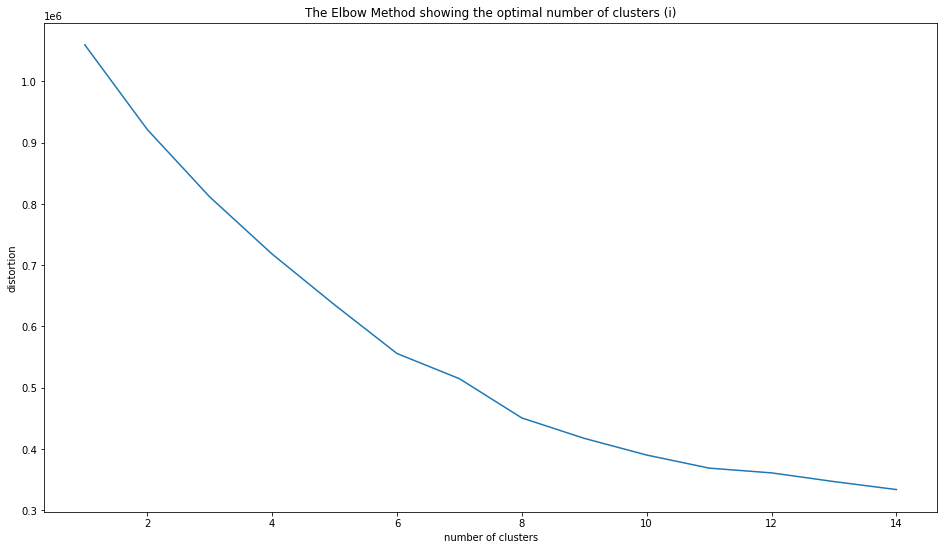

In [82]:
#Using elbow method to determine the number of clusters
w = []
k = range(1,15)
for i in k:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pca_x2)
    w.append(kmeans.inertia_)
    
plt.figure(figsize=(16,9))
plt.plot(k,w)
plt.xlabel("number of clusters")
plt.ylabel("distortion")
plt.title('The Elbow Method showing the optimal number of clusters (i)')

plt.show()

In [68]:
data_small[categorical_cols] = oe.inverse_transform(data_small[categorical_cols])

/Users/premchandran/opt/anaconda3/envs/python38/lib/python3.8/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [69]:
data_small

,hotel,had_cancellations,is_repeated_guest,driving,adr,customer_type,market_segment,family_type,preferred_day,total_of_special_requests,room_change
0,Resort Hotel,False,0,False,0.00,Transient,Direct,Couple,weekday,0,False
75559,City Hotel,False,0,False,80.00,Transient,Offline TA/TO,Single,weekday,0,False
75560,City Hotel,False,0,False,101.50,Transient,Offline TA/TO,Couple,weekday,0,False
75561,City Hotel,False,0,False,101.50,Transient,Offline TA/TO,Couple,weekday,0,False
75562,City Hotel,False,0,False,101.50,Transient,Offline TA/TO,Couple,weekday,0,False
...,...,...,...,...,...,...,...,...,...,...,...
40039,Resort Hotel,False,0,False,207.03,Transient,Online TA,Couple,weekday,1,False
40040,Resort Hotel,False,0,True,312.29,Transient,Online TA,Family,weekday,1,False
13794,Resort Hotel,False,0,False,207.00,Transient,Online TA,Couple,weekday,2,False
40038,Resort Hotel,False,0,False,114.80,Contract,Offline TA/TO,Couple,weekday,0,False


In [70]:
clusters = KMeans(n_clusters=7, random_state=15).fit(pca_x2)

#Predict the cluster for each row
data_small['clusters'] = clusters.predict(pca_x2)

#find the cluster center
centers = clusters.cluster_centers_

/var/folders/l9/swvqvt0552gfk3662mhw83b00000gn/T/ipykernel_44804/3224003093.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
data_small

,hotel,had_cancellations,is_repeated_guest,driving,adr,customer_type,market_segment,family_type,preferred_day,total_of_special_requests,room_change,clusters
0,Resort Hotel,False,0,False,0.00,Transient,Direct,Couple,weekday,0,False,4
75559,City Hotel,False,0,False,80.00,Transient,Offline TA/TO,Single,weekday,0,False,4
75560,City Hotel,False,0,False,101.50,Transient,Offline TA/TO,Couple,weekday,0,False,4
75561,City Hotel,False,0,False,101.50,Transient,Offline TA/TO,Couple,weekday,0,False,4
75562,City Hotel,False,0,False,101.50,Transient,Offline TA/TO,Couple,weekday,0,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...
40039,Resort Hotel,False,0,False,207.03,Transient,Online TA,Couple,weekday,1,False,2
40040,Resort Hotel,False,0,True,312.29,Transient,Online TA,Family,weekday,1,False,5
13794,Resort Hotel,False,0,False,207.00,Transient,Online TA,Couple,weekday,2,False,2
40038,Resort Hotel,False,0,False,114.80,Contract,Offline TA/TO,Couple,weekday,0,False,2


In [73]:
data_small.groupby('clusters').describe()['adr']

,count,mean,std,min,25%,50%,75%,max
clusters,,,,,,,,
0,11179.0,103.160266,42.215920,0.00,76.50,95.50,122.40,359.00
1,10778.0,85.188401,46.065257,0.00,52.27,80.00,110.00,365.00
2,42323.0,123.293067,49.014251,0.00,89.10,116.10,149.00,510.00
3,3683.0,63.189158,42.026767,-6.38,39.00,65.00,80.00,349.00
4,37631.0,87.275712,35.899021,0.00,63.75,85.00,108.00,323.00
5,6765.0,117.891833,89.606610,0.00,68.50,104.91,154.38,5400.00
6,5454.0,78.081819,29.118308,0.00,62.00,70.00,90.00,276.53


<AxesSubplot:xlabel='hotel', ylabel='clusters'>

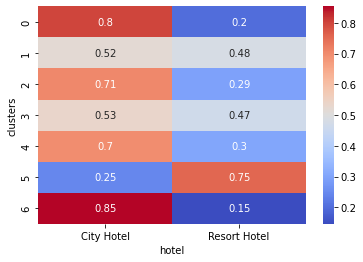

In [74]:
#group customers by different dimensions - Hotel
df1 = pd.pivot_table(data_small, index='clusters', columns = ['hotel'], aggfunc='size')
total = df1.sum(axis=1)
df1['City Hotel'] = df1['City Hotel'] / total
df1['Resort Hotel'] = df1['Resort Hotel'] / total
sns.heatmap(df1, annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='had_cancellations', ylabel='clusters'>

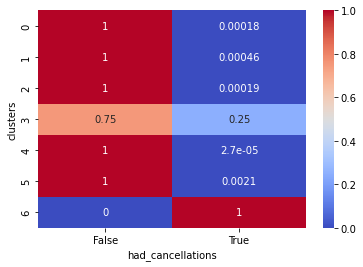

In [75]:
# whether customer group had cancellations or not
df2 = pd.pivot_table(data_small,index='clusters', columns = ['had_cancellations'], aggfunc='size')
df2.fillna(0, inplace=True)
total = df2.sum(axis=1)
df2[False] = df2[False] / total
df2[True] = df2[True] / total
sns.heatmap(df2, annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='is_repeated_guest', ylabel='clusters'>

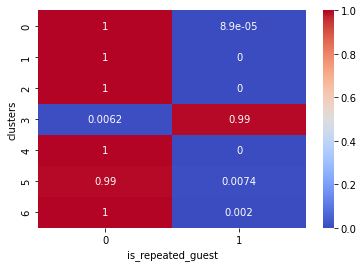

In [76]:
df3 = pd.pivot_table(data_small,index='clusters', columns = ['is_repeated_guest'], aggfunc='size')
df3.fillna(0, inplace=True)
total = df3.sum(axis=1)
df3[0] = df3[0] / total
df3[1] = df3[1] / total
sns.heatmap(df3, annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='driving', ylabel='clusters'>

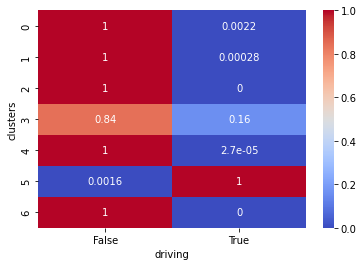

In [77]:
df4 = pd.pivot_table(data_small,index='clusters', columns = ['driving'], aggfunc='size')
df4.fillna(0, inplace=True)
total = df4.sum(axis=1)
df4[False] = df4[False] / total
df4[True] = df4[True] / total
sns.heatmap(df4, annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='customer_type', ylabel='clusters'>

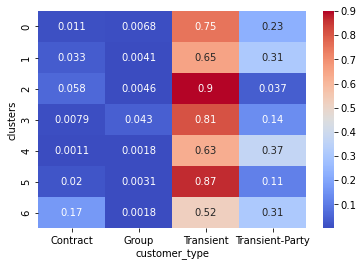

In [78]:
df5 = pd.pivot_table(data_small,index='clusters', columns = ['customer_type'], aggfunc='size')
df5.fillna(0, inplace=True)
total = df5.sum(axis=1)
df5['Contract'] = df5['Contract'] / total
df5['Group'] = df5['Group'] / total
df5['Transient'] = df5['Transient'] / total
df5['Transient-Party'] = df5['Transient-Party'] / total
sns.heatmap(df5, annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='market_segment', ylabel='clusters'>

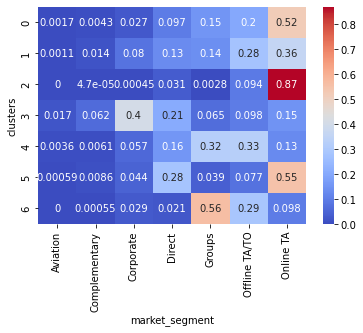

In [79]:
df6 = pd.pivot_table(data_small,index='clusters', columns = ['market_segment'], aggfunc='size')
df6.fillna(0, inplace=True)
total = df6.sum(axis=1)
df6['Aviation'] = df6['Aviation'] / total
df6['Complementary'] = df6['Complementary'] / total
df6['Corporate'] = df6['Corporate'] / total
df6['Direct'] = df6['Direct'] / total
df6['Groups'] = df6['Groups'] / total
df6['Offline TA/TO'] = df6['Offline TA/TO'] / total
df6['Online TA'] = df6['Online TA'] / total
sns.heatmap(df6, annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='family_type', ylabel='clusters'>

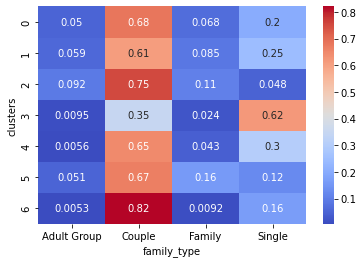

In [80]:
df7 = pd.pivot_table(data_small,index='clusters', columns = ['family_type'], aggfunc='size')
df7.fillna(0, inplace=True)
total = df7.sum(axis=1)
df7['Adult Group'] = df7['Adult Group'] / total
df7['Couple'] = df7['Couple'] / total
df7['Family'] = df7['Family'] / total
df7['Single'] = df7['Single'] / total
sns.heatmap(df7, annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='preferred_day', ylabel='clusters'>

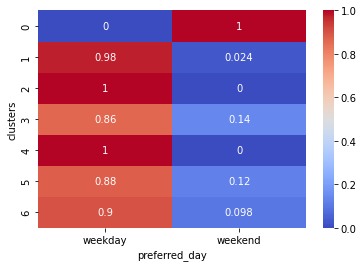

In [81]:
df8 = pd.pivot_table(data_small,index='clusters', columns = ['preferred_day'], aggfunc='size')
df8.fillna(0, inplace=True)
total = df8.sum(axis=1)
df8['weekday'] = df8['weekday'] / total
df8['weekend'] = df8['weekend'] / total
sns.heatmap(df8, annot=True, cmap='coolwarm')